## Computational Neuroscience Assignment 6

### Authors:
* Jochem Beurskens s4637801
* Kirina van der Bijl S1061566
* Arne Diehl S4451392

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits import mplot3d
import scipy as sp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import optimize, integrate
import networkx as nx
import sys

## 1.a Calculate the entropy of the binary process which gives 1 (a spike) with probability r∆t, and 0 (no spike) with probability 1-r$\Delta$t.

A binary process is also called a bernoulli process.
The entropy is defined as $$H=-\sum_ip_i\log_2(p_i)$$
There are two possible outcomes (spike or no spike), which happen with $p_{spike}= r*\Delta t$ and $p_{no spike}=1-r*\Delta t$
Thus for a single event this specific binary process, the entropy is given by this:
$$H=-(r*\Delta t)\log_2(r*\Delta t)-(1- r*\Delta t)\log_2(1-r*\Delta t)$$
Since we operate under the assumption of modelling a poisson process that is iid and that r is a rate per second, we have that the rate is 
$$H=\dfrac{1}{\Delta t}(-(r*\Delta t)\log_2(r*\Delta t)-(1- r*\Delta t)\log_2(1-r*\Delta t))$$
$$H=(-(r)\log_2(r*\Delta t)-(\dfrac{1}{\Delta t}- r)\log_2(1-r*\Delta t))$$


## 1.b The interspike interval distribution is exponential: $p(t)=r\exp(-rt)$. Determine the entropy per interspike interval and convert it to an entropy rate.

For a given interspike interval distribution, $p(t)$, we have an entropy and entropy rate as given by formulas 4.52 and 4.53 from the Dayan-Abott book. Here we will show the derivation of the result of 4.53.

$$p(t)=r*exp(-r t)$$$$ \dot{H} = - r * \int_{0}^{\infty} dt p(t)*log_{2}(p(t)\Delta t)$$ solving the integral with $p(t)$ plugged in: $$ \int_{0}^{\infty}r*exp(-rt)*log_{2}(r*exp(-rt)*\Delta t) dt $$$$= \int_{0}^{\infty}r*exp(-rt)*\dfrac{log_{e}(r*exp(-rt)*\Delta t)}{log_{2}(2)} dt $$$$= \dfrac{1}{ln(2)}*\int_{0}^{\infty}r*exp(-rt)*(-rt+ln(r*\Delta t) dt $$$$=\dfrac{1}{ln(2)}* \left( \int_{0}^{\infty} -r^2*t*exp(-r*t) dt + \int_{0}^{\infty} ln(r*\Delta t)*r*exp(-r*t) dt \right) = Q$$

These are standard exponential integrals: 
$$\int_{0}^{\infty}exp(-a*x^b)dx= \dfrac{\Gamma(\dfrac{1}{b})}{a^bb}$$$$
\int_{0}^{\infty}x^n * exp(-a*x^b)dx = \dfrac{1}{b}*a^{\dfrac{-n+1}{b}}*\Gamma(\dfrac{n+1}{b})$$
So we obtain in the integral above:

$$Q = \dfrac{1}{ln(2)} * \left( -r^2 * 1*r^{-2}*1+ ln(r*\Delta t)* 1*r*r^{-1}*1 \right) $$$$= \dfrac{1}{ln(2)} * \left( -1+ ln(r*\Delta t) \right)$$

And thus we get for the entropy rate:

$$\dot{H}= \dfrac{-r}{ln(2)}* \left( -1+ ln(r*\Delta t) \right) = \dfrac{r}{ln(2)}* \left( 1- ln(r*\Delta t) \right)$$

## 2.a Determine what the exact mutual information between r and s is.


We want to calculate $I(r|s) = H(r) - H(r|s)$

For $H(r)$ we have $H(r)=-\sum p(r)\log_2(p(r))$

For $H(r|s)$ we have $H(r|s)=-\sum_s p(s) \sum_rp(r|s)log_2(p(r|s))$

From this follows a more concise description of I(r|s):
$$I(r|s)=-\sum_sp(s)\sum_rp(r|s)log_2\dfrac{p(r|s)}{p(r)}$$
Given the input
$$p(s) = 
\left(
\begin{array}{cc}
\dfrac{1}{3} \\
\dfrac{1}{3} \\
\dfrac{1}{3}
\end{array}
\right)
\quad
p(r|s) = 
\left(
\begin{array}{cc}
\dfrac{2}{3} & \dfrac{5}{18} & \dfrac{1}{18}\\
\dfrac{5}{18} & \dfrac{2}{3} & \dfrac{1}{18}\\
\dfrac{1}{36} & \dfrac{1}{36} & \dfrac{4}{9}\\
\dfrac{1}{36} & \dfrac{1}{36} & \dfrac{4}{9}\\
\end{array}
\right)
$$

In [117]:
def calculate_I(prs, pr, ps):
    return np.sum([s_p * np.sum([prs[r_idx, s_idx]*np.log2(prs[r_idx, s_idx]/pr[r_idx]) for r_idx, _ in enumerate(prs[:,s_idx])]) for s_idx,s_p in enumerate(ps)])

In [118]:
ps_exact = np.array([1/3,1/3,1/3])
prs_exact = np.array([[2/3,5/18,1/18],
                [5/18,2/3,1/18],
                [1/36,1/36,4/9],
                [1/36,1/36,4/9]])
pr_exact = prs_exact @ ps_exact
print("Mutual information I(r|s)=", calculate_I(prs_exact,pr_exact,ps_exact))

Mutual information I(r|s)= 0.62352603568961


## 2.b Write a program that estimates p(rs) given p(rs) and N as input

In [119]:
def sample_prs_naive(prs_exact, N):
    samples = np.zeros_like(prs_exact)
    for s in range(prs_exact.shape[1]):
        cump = np.cumsum(prs_exact[:,s])
        for ri in np.random.uniform(high=cump[-1],size=(N)):
            samples[0,s] += 1 if ri<cump[0] else 0
            for r in range(1,len(cump)):
                samples[r,s] += 1 if ri>=cump[r-1] and ri<cump[r] else 0
    return samples/N

 ## 2.c Verify that your program works by comparing with the given values from p(rs)

In [120]:
ps_exact = np.array([1/3,1/3,1/3])
prs_exact = np.array([[2/3,5/18,1/18],
                [5/18,2/3,1/18],
                [1/36,1/36,4/9],
                [1/36,1/36,4/9]])
pr_exact = prs_exact @ ps_exact

print("Exact distribution p(r|s):\n")
print(prs_exact)
print("Estimated distribution p(r|s):\n")
print(sample_prs_naive(prs_exact,100000))

Exact distribution p(r|s):

[[0.66666667 0.27777778 0.05555556]
 [0.27777778 0.66666667 0.05555556]
 [0.02777778 0.02777778 0.44444444]
 [0.02777778 0.02777778 0.44444444]]
Estimated distribution p(r|s):

[[0.66772 0.27618 0.05622]
 [0.27707 0.66722 0.05496]
 [0.02717 0.02812 0.44622]
 [0.02804 0.02848 0.4426 ]]


We can see that our program reproduces the given values with a certain margin of error.

## 2.d Strong's method for Bias reduction
Strong et al formulated a function that fits to noisy sampling estimates, which can be extrapolated to calculate the noise free estimate. We denote strongs formula as follows:

In [121]:
def strong(N, a, b, h_inf):
    return h_inf + a/N + b/(N**2)

## 2.d.1 Estimate H(r) as a function of N and calculate $H(r)_{\infty}$ using Strong's method

To calculate $H(r)$ we need to first calculate p(r), which we do as follows:
$$p(r) = p(r|s) \cdot p(s)$$
After this we can calculate H(r) using the following formula:
$$H(r)=-\sum p(r)\log_2(p(r))$$
Since we want to estimate H(r as a function of N, we need to use the estimate of the distribution p(r|s) instead of the actual distribution)

In [122]:
def calculate_hr(pr):
    return - np.sum([r_p * np.log2(r_p) for r_p in pr])

In [123]:
def sample_hr_naive(prs_exact,ps_exact,N):
    prs_naive = sample_prs_naive(prs_exact,N) + sys.float_info.epsilon
    pr_naive = prs_naive @ ps_exact
    return calculate_hr(pr_naive)

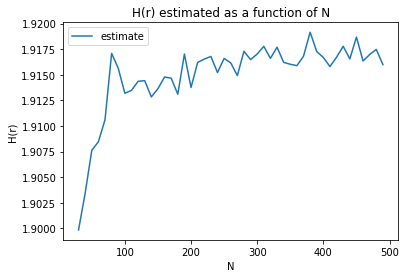

H(r) infinite: 1.9178827330587642


In [124]:
ps_exact = np.array([1/3,1/3,1/3])
prs_exact = np.array([[2/3,5/18,1/18],
                [5/18,2/3,1/18],
                [1/36,1/36,4/9],
                [1/36,1/36,4/9]])

repeat=100
nspace = np.arange(30,500,10)
hr_naive = np.sum([np.array([sample_hr_naive(prs_exact, ps_exact, n) for n in nspace]) for _ in range(repeat)], axis=0)/repeat

plt.title('H(r) estimated as a function of N')
plt.ylabel('H(r)')
plt.xlabel('N')
plt.plot(nspace, hr_naive, label='estimate')
plt.legend()
plt.show()

hr_inf, _ = curve_fit(strong, nspace, hr_naive)
print("H(r) infinite:",hr_inf[2])

## 2.d.2 Estimate H(r|s) as a function of N Calculate $H(r|s)_{\infty}$ using Strong's method

To do the same thing for H(r|s) we will calculate the following:
$$H(r|s)=-\sum_s p(s) \sum_rp(r|s)log_2(p(r|s))$$


In [125]:
def calculate_hrs(prs, ps):
    return - np.sum([s_p * np.sum([prs[r_idx, s_idx]*np.log2(prs[r_idx, s_idx]) for r_idx, _ in enumerate(prs[:,s_idx])]) for s_idx,s_p in enumerate(ps)])

In [126]:
def sample_hrs_naive(prs_exact,ps_exact,N):
    prs_naive = sample_prs_naive(prs_exact,N) + sys.float_info.epsilon
    return calculate_hrs(prs_naive, ps_exact)

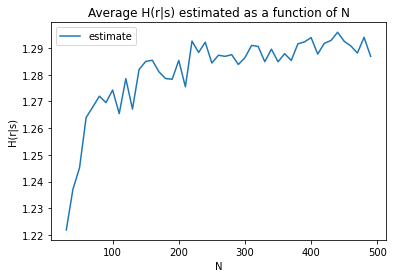

H(r|s) infinite: 1.2957158304054146


In [127]:
ps_exact = np.array([1/3,1/3,1/3])
prs_exact = np.array([[2/3,5/18,1/18],
                [5/18,2/3,1/18],
                [1/36,1/36,4/9],
                [1/36,1/36,4/9]])

repeat = 100
nspace = np.arange(30,500,10)
hrs_naive = np.sum([np.array([sample_hrs_naive(prs_exact, ps_exact, n) for n in nspace]) for _ in range(repeat)], axis=0)/repeat

plt.title('Average H(r|s) estimated as a function of N')
plt.ylabel('H(r|s)')
plt.xlabel('N')
plt.plot(nspace, hrs_naive, label='estimate')
plt.legend()
plt.show()

hrs_inf, _ = curve_fit(strong, nspace, hrs_naive)
print("H(r|s) infinite:",hrs_inf[2])

## 2.d.3 Calculate the mutual information estimate using Strong's method

In [128]:
print("Bias reduced mutual informtion I_inf(r;s):",hr_inf[2] - hrs_inf[2])

Bias reduced mutual informtion I_inf(r;s): 0.6221669026533496


As we can see, the mutual information estimate after bias reduction using strongs method is very close to the exact mutual information.

## 2.d.4 Calculate the bias at N=30 using strongs method

In [129]:
print("estimate H(r) bias for N=30", strong(30, *hr_inf) - hr_inf[2])
print("estimate H(r|s) bias for N=30", strong(30, *hrs_inf) - hrs_inf[2])

estimate H(r) bias for N=30 -0.018697639810887567
estimate H(r|s) bias for N=30 -0.0745386538116819


We can see that the estimate using the fit tells us that the bias should be about -0.07 which is expected given that we know the bias of entropy of r and that of r given s to be negative.

## 3.1 Manual calculation of H(r) and H(r|s)
In this exercise we will calculate both H(R) and H(R|s). Firstly H(R|s):

$ H(R|s)=-\sum_{r,s}^{} p(r_a,r_b|s) * log_{2}(p(r_a,r_b|s)) = - 1 * 1/2 * \left( \dfrac{4}{18}*log_{2}(\dfrac{4}{18}) + \dfrac{3}{18}*log_{2}(\dfrac{3}{18} ) +...+ \dfrac{1}{18}*log_{2}(\dfrac{1}{18}) + \dfrac{1}{18}*log_{2}(\dfrac{1}{18}) + \dfrac{1}{18}*log_{2}(\dfrac{1}{18}) + \dfrac{7}{144}*log_{2}(\dfrac{7}{144} +\dfrac{1}{144}*log_{2}(\dfrac{1}{144}) +...+\dfrac{3}{18}*log_{2}(\dfrac{3}{18})+\dfrac{4}{18}*log_{2}(\dfrac{4}{18}) \right) = 2.76781425... $

Notice that in the above we skipped over the term $0log(0)$, as this term has no probability we assumed this to be equal 0.

Next we will have a look at H(R), but in order to compute this we firstly need to rewrite the matrices $p(r_a,r_b|s_i)$ into a 9 by 2 matrix. We thus need to understand the meaning of the positions in the current 3 by 3 matrices. Each position in these matrices means the response for a combination of $r_a,r_b$ where the given stimulus $s_i$ determines in which of the two matrices you are. We can order this into the 9 by 2 matrix by making the columns represent the 2 different stimuli, $s$, and the 9 rows the different combinations of $r_a,r_b$. We get: 

$p(\vec{r}|\vec{s})= \begin{bmatrix} \dfrac{4}{18} & \dfrac{1}{18} \\ \dfrac{3}{18} & \dfrac{7}{144} \\\dfrac{1}{18} & \dfrac{1}{144} \\\dfrac{3}{18} & \dfrac{1}{18} \\\dfrac{4}{18} & \dfrac{4}{18} \\\dfrac{1}{18} & \dfrac{3}{18} \\\dfrac{1}{18} & \dfrac{1}{18} \\0 & \dfrac{3}{18} \\\dfrac{1}{18} & \dfrac{4}{18} \\ \end{bmatrix}, p(\vec{s})= \begin{bmatrix} \dfrac{1}{2} \\ \dfrac{1}{2} \end{bmatrix} \rightarrow p(\vec{r})=p(\vec{r}|\vec{s})\cdot p(\vec{s})=\begin{bmatrix} \dfrac{5}{36} \\ \dfrac{31}{288}  \\\dfrac{1}{32}\\\dfrac{2}{18}  \\\dfrac{4}{18} \\\dfrac{2}{18} \\\dfrac{1}{18}  \\\dfrac{1}{12} \\\dfrac{5}{36}\\ \end{bmatrix}$

And now we can calculate H(R):

$H(R) = -\sum_{r} p(r)*log_2(p(r)) = - \left( \dfrac{5}{36} * log_{2}(\dfrac{5}{36}) + \dfrac{31}{288} * log_{2}(\dfrac{31}{288}) + ... + \dfrac{1}{12} * log_{2}(\dfrac{1}{12}) +\dfrac{5}{36} * log_{2}(\dfrac{5}{36}) \right) = 3.02883348$

## 3.a.1 Calculate H(r) exactly

In [130]:
prs1 = np.array([[4/18,3/18,1/18],
                 [3/18,4/18,1/18],
                 [1/18,0,1/18]])
prs2 = np.array([[1/18,7/144,1/144],
                 [1/18,4/18,3/18],
                 [1/18,3/18,4/18]])
prs_exact = np.zeros((9,2))
prs_exact[:,0]=prs1.reshape((9))
prs_exact[:,1]=prs2.reshape((9))
ps_exact = np.array([0.5,0.5])
pr_exact = prs_exact @ ps_exact

print("H(r)=", calculate_hr(pr_exact))

H(r)= 3.0105404242087337


## 3.a.2 Calculate H(r|s) exactly

In [131]:
prs1 = np.array([[4/18,3/18,1/18],
                 [3/18,4/18,1/18],
                 [1/18,0,1/18]])
prs2 = np.array([[1/18,7/144,1/144],
                 [1/18,4/18,3/18],
                 [1/18,3/18,4/18]])
prs_exact = np.zeros((9,2))
prs_exact[:,0]=prs1.reshape((9))
prs_exact[:,1]=prs2.reshape((9))
ps_exact = np.array([0.5,0.5])
pr_exact = prs_exact @ ps_exact

print("H(r|s)=", calculate_hrs(prs_exact+sys.float_info.epsilon, ps_exact))

H(r|s)= 2.767814291290814


## 3.a.3 Calculate I(r;s) exactly

In [132]:
prs1 = np.array([[4/18,3/18,1/18],
                 [3/18,4/18,1/18],
                 [1/18,0,1/18]])
prs2 = np.array([[1/18,7/144,1/144],
                 [1/18,4/18,3/18],
                 [1/18,3/18,4/18]])
prs_exact = np.zeros((9,2))
prs_exact[:,0]=prs1.reshape((9))
prs_exact[:,1]=prs2.reshape((9))
ps_exact = np.array([0.5,0.5])
pr_exact = prs_exact @ ps_exact

print("Mutual information I(r|s)=", calculate_I(prs_exact+sys.float_info.epsilon,pr_exact,ps_exact))

Mutual information I(r|s)= 0.242726132917926


## 3.b.1 Estimate the bias in the entropies for N=100

In [134]:
prs1 = np.array([[4/18,3/18,1/18],
                 [3/18,4/18,1/18],
                 [1/18,0,1/18]])
prs2 = np.array([[1/18,7/144,1/144],
                 [1/18,4/18,3/18],
                 [1/18,3/18,4/18]])
prs_exact = np.zeros((9,2))
prs_exact[:,0]=prs1.reshape((9))
prs_exact[:,1]=prs2.reshape((9))
ps_exact = np.array([0.5,0.5])
pr_exact = prs_exact @ ps_exact

repeat=1000
hr_naive = np.mean([sample_hr_naive(prs_exact, ps_exact, 100) for _ in range(repeat)], axis=0)
hr_exact = calculate_hr(pr_exact)
print("Bias in H(r) estimate:",hr_naive - hr_exact)

hrs_naive = np.mean([sample_hrs_naive(prs_exact, ps_exact, 100) for _ in range(repeat)], axis=0)
hrs_exact = calculate_hrs(prs_exact+sys.float_info.epsilon, ps_exact)
print("Bias in H(r|s) estimate:",hrs_naive - hrs_exact)

Bias in H(r) estimate: -0.029513517806536438
Bias in H(r|s) estimate: -0.05611356565272008


## 3.b.1 Estimate the bias in the entropies for N=1000

In [135]:
prs1 = np.array([[4/18,3/18,1/18],
                 [3/18,4/18,1/18],
                 [1/18,0,1/18]])
prs2 = np.array([[1/18,7/144,1/144],
                 [1/18,4/18,3/18],
                 [1/18,3/18,4/18]])
prs_exact = np.zeros((9,2))
prs_exact[:,0]=prs1.reshape((9))
prs_exact[:,1]=prs2.reshape((9))
ps_exact = np.array([0.5,0.5])
pr_exact = prs_exact @ ps_exact

repeat=1000
hr_naive = np.mean([sample_hr_naive(prs_exact, ps_exact, 1000) for _ in range(repeat)], axis=0)
hr_exact = calculate_hr(pr_exact)
print("Bias in H(r) estimate:",hr_naive - hr_exact)

hrs_naive = np.mean([sample_hrs_naive(prs_exact, ps_exact, 1000) for _ in range(repeat)], axis=0)
hrs_exact = calculate_hrs(prs_exact+sys.float_info.epsilon, ps_exact)
print("Bias in H(r|s) estimate:",hrs_naive - hrs_exact)

Bias in H(r) estimate: -0.00281931389411616
Bias in H(r|s) estimate: -0.00504566611445334


## 3.c.1 Write a program to calculate the indipendent distribution

In [145]:
def sample_prs_ind(prs_naive, ps_exact, N):
    prs_neuron_a = np.empty((3,2))
    prs_neuron_a[:,0] = np.sum(prs_naive[:,0].reshape((3,3)), axis=0)
    prs_neuron_a[:,1] = np.sum(prs_naive[:,1].reshape((3,3)), axis=0)

    prs_neuron_b = np.empty((3,2))
    prs_neuron_b[:,0] = np.sum(prs_naive[:,0].reshape((3,3)), axis=1)
    prs_neuron_b[:,1] = np.sum(prs_naive[:,1].reshape((3,3)), axis=1)

    prs_ind = np.zeros((9,2))
    prs_ind[:,0]=np.outer(prs_neuron_a[:,0], prs_neuron_b[:,0]).reshape((9))
    prs_ind[:,0]/=np.sum(prs_ind[:,0])
    prs_ind[:,1]=np.outer(prs_neuron_a[:,1], prs_neuron_b[:,1]).reshape((9))
    prs_ind[:,1]/=np.sum(prs_ind[:,1])
    return prs_ind

## 3.c.2 Write a program to calculate the shuffled distribution

In [146]:
def shuffle_prs_naive(prs_naive, N):
    samples = prs_naive * N
    for stimulus in range(samples.shape[1]):
        sample_matrix = samples[:,stimulus].reshape((3,3)).astype(int)
        sample_list = np.array([[a,b] for b, row in enumerate(sample_matrix) for a, element in enumerate(row) for _ in range(element)])
        np.random.shuffle(sample_list[:,0])
        sample_matrix = np.zeros_like(sample_matrix)
        for a, b in sample_list: sample_matrix[b, a] += 1
        samples[:,stimulus] = sample_matrix.reshape((9))
    return samples/N

## 3.d Calculate the bias reduced entropy using $H=H_{naive}-H_{shuffle}+H_{ind}$

In [154]:
prs1 = np.array([[4/18,3/18,1/18],
                 [3/18,4/18,1/18],
                 [1/18,0,1/18]])
prs2 = np.array([[1/18,7/144,1/144],
                 [1/18,4/18,3/18],
                 [1/18,3/18,4/18]])
prs_exact = np.zeros((9,2))
prs_exact[:,0]=prs1.reshape((9))
prs_exact[:,1]=prs2.reshape((9))
ps_exact = np.array([0.5,0.5])
pr_exact = prs_exact @ ps_exact

hr_naive = []
hr_ind = []
hr_shuffle = []
hrs_naive = []
hrs_ind = []
hrs_shuffle = []

for _ in range(1000):
  N = 1000
  prs_naive = sample_prs_naive(prs_exact, N)

  prs_naive = sample_prs_naive(prs_exact, N)
  prs_ind = sample_prs_ind(prs_naive, ps_exact, N)
  prs_shuffle = shuffle_prs_naive(prs_naive, N)

  pr_naive = prs_naive @ ps_exact
  pr_ind = prs_ind @ ps_exact
  pr_shuffle = prs_shuffle @ ps_exact

  hr_naive.append(calculate_hr(pr_naive))
  hr_ind.append(calculate_hr(pr_ind))
  hr_shuffle.append(calculate_hr(pr_shuffle))

  hrs_naive.append(calculate_hrs(prs_naive+sys.float_info.epsilon, ps_exact))
  hrs_ind.append(calculate_hrs(prs_ind, ps_exact))
  hrs_shuffle.append(calculate_hrs(prs_shuffle, ps_exact))

hr_naive = np.mean(hr_naive)
hr_ind = np.mean(hr_ind)
hr_shuffle = np.mean(hr_shuffle)
hr_exact = calculate_hr(pr_exact)

hrs_naive = np.mean(hrs_naive)
hrs_ind = np.mean(hrs_ind)
hrs_shuffle = np.mean(hrs_shuffle)
hrs_exact = calculate_hrs(prs_exact+sys.float_info.epsilon, ps_exact)

print("H(r)=", hr_naive)
print("Bias of H(r)=", hr_naive - hr_exact)
print("Bias reduced H(r)=", (hr_naive) - (hr_shuffle) + (hr_ind))
print("H(r|s)=", hrs_naive)
print("Bias of H(r|s)=", hrs_naive - hrs_exact)
print("Bias reduced H(r|s)=", hrs_naive - hrs_shuffle + hrs_ind)
print("Mutual information I(r|s)=", hr_naive - hrs_naive)
print("Bias of mutual information I(r|s)=", (hr_naive - hrs_naive) - (hr_exact - hrs_exact))
print("Bias reduced mutual information I(r|s)=", (hr_naive - hr_shuffle + hr_ind) - (hrs_naive - hrs_shuffle + hrs_ind))

H(r)= 3.0076065556386338
Bias of H(r)= -0.002933868570099918
Bias reduced H(r)= 3.0087747472620543
H(r|s)= 2.762218220876686
Bias of H(r|s)= -0.005596070414128018
Bias reduced H(r|s)= 2.7650402505200304
Mutual information I(r|s)= 0.24538833476194766
Bias of mutual information I(r|s)= 0.0026622018440281003
Bias reduced mutual information I(r|s)= 0.24373449674202385


The results above are exactly as expected. We see that both the bias of H(r) and H(r|s) is negative. From this follows that the bias reduced entropies should be larger than the naive estimate. This is also the case. For the mutual information we see the inverse situation, as expected. The bias in the mutual information is positive, while the bias reduced version of the mutual information is smaller than the naive estimate of the mutual information. This shows that the procedure by Ince et al works on average.